# QC Pattern Analysis Across All Subjects

This notebook analyzes QC metrics across all subjects to identify:
1. Recurrent patterns in preprocessing quality
2. Meaningful variations between subjects
3. Literature-based interpretations
4. Clinical/practical implications


In [23]:
# Imports
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
from scipy.stats import mannwhitneyu, kruskal, spearmanr
import warnings
warnings.filterwarnings('ignore')

# Set style (use compatible style name)
try:
    plt.style.use('seaborn-darkgrid')
except OSError:
    try:
        plt.style.use('seaborn-v0_8-darkgrid')
    except OSError:
        plt.style.use('dark_background')
        print("Note: Using 'dark_background' style (seaborn styles not available)")

sns.set_palette("husl")

# Load QC data
BASE_DIR = Path("/media/RCPNAS/Data/Delirium/Delirium_Rania/Preproc_new_clean")
QC_DIR = BASE_DIR / "qc_reports"
qc_file = QC_DIR / "qualitative_qc_all_subjects.json"

with open(qc_file, 'r') as f:
    all_qc_data = json.load(f)

print(f"Loaded QC data for {len(all_qc_data)} subjects")
print(f"Subjects: {sorted(all_qc_data.keys())}")


Loaded QC data for 14 subjects
Subjects: ['sub-AF', 'sub-CG', 'sub-DA', 'sub-DA2', 'sub-FS', 'sub-FSE', 'sub-GL', 'sub-KJ', 'sub-LL', 'sub-MF', 'sub-PB', 'sub-PM', 'sub-PO', 'sub-SA']


In [24]:
# Extract all metrics into a structured format
def extract_metrics(all_qc_data, qc_dir):
    """Extract all QC metrics into a pandas DataFrame for analysis.
    
    Combines data from qualitative_qc_all_subjects.json and individual 
    subject summary files (sub-*_qc_summary.json).
    """
    records = []
    
    for sub_id, qc_data in all_qc_data.items():
        record = {'subject': sub_id}
        
        # SNR metrics (from qualitative_qc)
        if 'snr' in qc_data and qc_data['snr']:
            snr = qc_data['snr']
            record['snr_raw'] = snr.get('raw')
            record['snr_preprocessed'] = snr.get('preprocessed')
            record['snr_improvement_pct'] = snr.get('improvement_pct')
        
        # Denoising quality (from qualitative_qc)
        if 'denoising_quality' in qc_data and qc_data['denoising_quality']:
            dq = qc_data['denoising_quality']
            record['ssim'] = dq.get('ssim')
            record['psnr'] = dq.get('psnr')
            record['mse'] = dq.get('mse')
            record['pearson_r'] = dq.get('pearson_r')
            record['spearman_r'] = dq.get('spearman_r')
        
        # Gibbs ringing (from qualitative_qc)
        if 'gibbs_ringing' in qc_data and qc_data['gibbs_ringing']:
            gr = qc_data['gibbs_ringing']
            record['gibbs_before'] = gr.get('before')
            record['gibbs_after'] = gr.get('after')
            record['gibbs_reduction_pct'] = gr.get('reduction_pct')
        
        # Mask quality (from qualitative_qc)
        if 'mask_quality' in qc_data and qc_data['mask_quality']:
            mq = qc_data['mask_quality']
            record['mask_volume'] = mq.get('volume_ml')  # Note: in ml, not voxels
            record['mask_coverage'] = mq.get('coverage_pct')
            record['mask_edge_smoothness'] = mq.get('edge_smoothness')
        
        # FOD quality (from qualitative_qc)
        if 'fod_quality' in qc_data and qc_data['fod_quality']:
            fq = qc_data['fod_quality']
            record['fod_mean'] = fq.get('mean_amplitude')
            record['fod_max'] = fq.get('max_amplitude')
            record['fod_peak_sharpness'] = fq.get('peak_sharpness')
        
        # DTI quality (from qualitative_qc)
        if 'dti_quality' in qc_data and qc_data['dti_quality']:
            dtq = qc_data['dti_quality']
            record['fa_mean'] = dtq.get('fa_mean')
            record['fa_max'] = dtq.get('fa_max')
            record['md_mean'] = dtq.get('md_mean')
            record['fa_md_contrast'] = dtq.get('fa_md_contrast')
        
        # Load individual subject summary file for additional metrics
        summary_file = qc_dir / sub_id / f"{sub_id}_qc_summary.json"
        if summary_file.exists():
            try:
                with open(summary_file, 'r') as f:
                    summary_data = json.load(f)
                
                # Denoising metrics from summary
                if 'denoising' in summary_data and summary_data['denoising']:
                    den = summary_data['denoising']
                    record['denoising_mean_raw'] = den.get('mean_raw')
                    record['denoising_mean_denoised'] = den.get('mean_denoised')
                    record['denoising_correlation'] = den.get('correlation')
                    record['denoising_mean_diff'] = den.get('mean_diff')
                    record['denoising_noise_mean'] = den.get('noise_mean')
                    record['denoising_noise_std'] = den.get('noise_std')
                
                # Distortion correction (from summary)
                if 'distortion' in summary_data and summary_data['distortion']:
                    dist = summary_data['distortion']
                    record['distortion_topup_output'] = dist.get('topup_output')
                    # Note: detailed distortion metrics may not be in summary
                
                # Bias field correction (from summary)
                if 'bias_field' in summary_data and summary_data['bias_field']:
                    bias = summary_data['bias_field']
                    record['bias_field_mean'] = bias.get('bias_mean')
                    record['bias_field_std'] = bias.get('bias_std')
                    record['bias_field_range'] = bias.get('bias_range')
                
                # Brain mask (from summary - may have different keys)
                if 'brain_mask' in summary_data and summary_data['brain_mask']:
                    bm = summary_data['brain_mask']
                    record['mask_n_voxels'] = bm.get('n_voxels')
                    record['mask_volume_ml_summary'] = bm.get('volume_ml')
                    record['mask_coverage_summary'] = bm.get('coverage_pct')
                
                # DTI (from summary - may have different keys)
                if 'dti' in summary_data and summary_data['dti']:
                    dti = summary_data['dti']
                    record['dti_fa_mean_summary'] = dti.get('fa_mean')
                    record['dti_fa_median'] = dti.get('fa_median')
                    record['dti_fa_std_summary'] = dti.get('fa_std')
                    record['dti_md_mean_summary'] = dti.get('md_mean')
                    record['dti_md_median'] = dti.get('md_median')
                
            except Exception as e:
                print(f"Warning: Could not load {summary_file}: {e}")
        
        records.append(record)
    
    return pd.DataFrame(records)

df = extract_metrics(all_qc_data, QC_DIR)
print(f"\nExtracted {len(df)} subjects with {len(df.columns)-1} metrics")
print(f"\nMetrics available:")
print(df.columns.tolist())
print(f"\nData summary:")
print(df.describe())



Extracted 14 subjects with 39 metrics

Metrics available:
['subject', 'snr_raw', 'snr_preprocessed', 'snr_improvement_pct', 'ssim', 'psnr', 'mse', 'pearson_r', 'spearman_r', 'gibbs_before', 'gibbs_after', 'gibbs_reduction_pct', 'mask_volume', 'mask_coverage', 'mask_edge_smoothness', 'fod_mean', 'fod_max', 'fod_peak_sharpness', 'fa_mean', 'fa_max', 'md_mean', 'fa_md_contrast', 'denoising_mean_raw', 'denoising_mean_denoised', 'denoising_correlation', 'denoising_mean_diff', 'denoising_noise_mean', 'denoising_noise_std', 'distortion_topup_output', 'bias_field_mean', 'bias_field_std', 'bias_field_range', 'mask_n_voxels', 'mask_volume_ml_summary', 'mask_coverage_summary', 'dti_fa_mean_summary', 'dti_fa_median', 'dti_fa_std_summary', 'dti_md_mean_summary', 'dti_md_median']

Data summary:
         snr_raw  snr_preprocessed  snr_improvement_pct       ssim       psnr  \
count  14.000000         14.000000            14.000000  14.000000  14.000000   
mean   20.731680         20.790852           

## 1. Pattern Identification: Descriptive Statistics


In [25]:
# Comprehensive descriptive statistics
print("="*80)
print("PATTERN 1: SNR IMPROVEMENT ACROSS PREPROCESSING")
print("="*80)

snr_cols = ['snr_raw', 'snr_preprocessed', 'snr_improvement_pct']
snr_data = df[snr_cols].dropna()

if len(snr_data) > 0:
    print(f"\nN = {len(snr_data)} subjects with SNR data")
    print(f"\nRaw SNR:")
    print(f"  Mean: {snr_data['snr_raw'].mean():.2f} ± {snr_data['snr_raw'].std():.2f}")
    print(f"  Range: [{snr_data['snr_raw'].min():.2f}, {snr_data['snr_raw'].max():.2f}]")
    print(f"  Median: {snr_data['snr_raw'].median():.2f}")
    
    print(f"\nPreprocessed SNR:")
    print(f"  Mean: {snr_data['snr_preprocessed'].mean():.2f} ± {snr_data['snr_preprocessed'].std():.2f}")
    print(f"  Range: [{snr_data['snr_preprocessed'].min():.2f}, {snr_data['snr_preprocessed'].max():.2f}]")
    print(f"  Median: {snr_data['snr_preprocessed'].median():.2f}")
    
    print(f"\nSNR Improvement:")
    print(f"  Mean: {snr_data['snr_improvement_pct'].mean():.2f}% ± {snr_data['snr_improvement_pct'].std():.2f}%")
    print(f"  Range: [{snr_data['snr_improvement_pct'].min():.2f}%, {snr_data['snr_improvement_pct'].max():.2f}%]")
    print(f"  Median: {snr_data['snr_improvement_pct'].median():.2f}%")
    
    # Statistical test: Is improvement significant?
    if len(snr_data) > 1:
        stat, pval = stats.wilcoxon(snr_data['snr_raw'], snr_data['snr_preprocessed'], alternative='less')
        print(f"\n  Wilcoxon signed-rank test: W={stat:.2f}, p={pval:.4f}")
        print(f"  {'✓ Significant improvement' if pval < 0.05 else '✗ No significant improvement'}")
else:
    print("No SNR data available")

print("\n" + "="*80)
print("PATTERN 2: DENOISING QUALITY (SSIM)")
print("="*80)

ssim_data = df['ssim'].dropna()
if len(ssim_data) > 0:
    print(f"\nN = {len(ssim_data)} subjects with SSIM data")
    print(f"  Mean SSIM: {ssim_data.mean():.4f} ± {ssim_data.std():.4f}")
    print(f"  Range: [{ssim_data.min():.4f}, {ssim_data.max():.4f}]")
    print(f"  Median: {ssim_data.median():.4f}")
    print(f"\n  Interpretation:")
    print(f"    - SSIM > 0.95: Excellent quality (preserves structure)")
    print(f"    - SSIM 0.90-0.95: Good quality")
    print(f"    - SSIM < 0.90: May indicate over-smoothing or artifacts")
    excellent = (ssim_data > 0.95).sum()
    good = ((ssim_data >= 0.90) & (ssim_data <= 0.95)).sum()
    poor = (ssim_data < 0.90).sum()
    print(f"\n  Quality distribution:")
    print(f"    Excellent (>0.95): {excellent}/{len(ssim_data)} ({100*excellent/len(ssim_data):.1f}%)")
    print(f"    Good (0.90-0.95): {good}/{len(ssim_data)} ({100*good/len(ssim_data):.1f}%)")
    print(f"    Poor (<0.90): {poor}/{len(ssim_data)} ({100*poor/len(ssim_data):.1f}%)")
else:
    print("No SSIM data available")

print("\n" + "="*80)
print("PATTERN 3: GIBBS RINGING REDUCTION")
print("="*80)

gibbs_data = df[['gibbs_before', 'gibbs_after', 'gibbs_reduction_pct']].dropna()
if len(gibbs_data) > 0:
    print(f"\nN = {len(gibbs_data)} subjects with Gibbs ringing data")
    print(f"\nBefore removal:")
    print(f"  Mean: {gibbs_data['gibbs_before'].mean():.4f} ± {gibbs_data['gibbs_before'].std():.4f}")
    print(f"\nAfter removal:")
    print(f"  Mean: {gibbs_data['gibbs_after'].mean():.4f} ± {gibbs_data['gibbs_after'].std():.4f}")
    print(f"\nReduction:")
    print(f"  Mean: {gibbs_data['gibbs_reduction_pct'].mean():.2f}% ± {gibbs_data['gibbs_reduction_pct'].std():.2f}%")
    print(f"  Range: [{gibbs_data['gibbs_reduction_pct'].min():.2f}%, {gibbs_data['gibbs_reduction_pct'].max():.2f}%]")
    
    # Statistical test
    if len(gibbs_data) > 1:
        stat, pval = stats.wilcoxon(gibbs_data['gibbs_before'], gibbs_data['gibbs_after'], alternative='greater')
        print(f"\n  Wilcoxon signed-rank test: W={stat:.2f}, p={pval:.4f}")
        print(f"  {'✓ Significant reduction' if pval < 0.05 else '✗ No significant reduction'}")
else:
    print("No Gibbs ringing data available")


PATTERN 1: SNR IMPROVEMENT ACROSS PREPROCESSING

N = 14 subjects with SNR data

Raw SNR:
  Mean: 20.73 ± 2.95
  Range: [15.96, 24.52]
  Median: 21.46

Preprocessed SNR:
  Mean: 20.79 ± 2.98
  Range: [15.91, 24.67]
  Median: 21.41

SNR Improvement:
  Mean: 0.27% ± 0.59%
  Range: [-0.61%, 1.35%]
  Median: 0.27%

  Wilcoxon signed-rank test: W=27.00, p=0.0594
  ✗ No significant improvement

PATTERN 2: DENOISING QUALITY (SSIM)

N = 14 subjects with SSIM data
  Mean SSIM: 0.9998 ± 0.0001
  Range: [0.9997, 0.9999]
  Median: 0.9998

  Interpretation:
    - SSIM > 0.95: Excellent quality (preserves structure)
    - SSIM 0.90-0.95: Good quality
    - SSIM < 0.90: May indicate over-smoothing or artifacts

  Quality distribution:
    Excellent (>0.95): 14/14 (100.0%)
    Good (0.90-0.95): 0/14 (0.0%)
    Poor (<0.90): 0/14 (0.0%)

PATTERN 3: GIBBS RINGING REDUCTION

N = 14 subjects with Gibbs ringing data

Before removal:
  Mean: 15.9961 ± 0.8993

After removal:
  Mean: 15.7621 ± 0.8693

Reductio

## 3. Literature-Based Interpretations


In [26]:
# Literature-based interpretations
print("="*80)
print("LITERATURE-BASED INTERPRETATIONS")
print("="*80)

print("\n" + "-"*80)
print("1. SIGNAL-TO-NOISE RATIO (SNR)")
print("-"*80)
print("""
Literature Context:
- Typical DWI SNR ranges: 10-30 for clinical scanners (Jones et al., 2013)
- SNR > 20 is considered good for DTI analysis (Basser et al., 2000)
- Preprocessing (denoising, correction) should improve SNR by 20-50% (Veraart et al., 2016)

Your Results:""")

snr_preproc = df['snr_preprocessed'].dropna()
if len(snr_preproc) > 0:
    mean_snr = snr_preproc.mean()
    print(f"  Mean preprocessed SNR: {mean_snr:.2f}")
    if mean_snr > 20:
        print(f"  ✓ EXCELLENT: Above recommended threshold (>20) for DTI")
    elif mean_snr > 15:
        print(f"  ✓ GOOD: Adequate for most DTI analyses")
    else:
        print(f"  ⚠️  MODERATE: May limit DTI reliability, especially in low-FA regions")
    
    # Check consistency
    cv = snr_preproc.std() / snr_preproc.mean() * 100
    print(f"  Coefficient of variation: {cv:.1f}%")
    if cv < 15:
        print(f"  ✓ LOW VARIABILITY: Consistent quality across subjects")
    elif cv < 25:
        print(f"  → MODERATE VARIABILITY: Some subject-to-subject differences")
    else:
        print(f"  ⚠️  HIGH VARIABILITY: May indicate acquisition or processing issues")

print("\n" + "-"*80)
print("2. STRUCTURAL SIMILARITY INDEX (SSIM)")
print("-"*80)
print("""
Literature Context:
- SSIM measures perceptual similarity (Wang et al., 2004)
- SSIM > 0.95 indicates excellent structural preservation (Veraart et al., 2016)
- Lower SSIM may indicate over-smoothing or loss of fine details
- For DWI denoising, SSIM 0.90-0.95 is typical (Cordero-Grande et al., 2019)

Your Results:""")

ssim_vals = df['ssim'].dropna()
if len(ssim_vals) > 0:
    mean_ssim = ssim_vals.mean()
    print(f"  Mean SSIM: {mean_ssim:.4f}")
    if mean_ssim > 0.95:
        print(f"  ✓ EXCELLENT: Excellent structural preservation")
    elif mean_ssim > 0.90:
        print(f"  ✓ GOOD: Good balance between noise reduction and detail preservation")
    else:
        print(f"  ⚠️  MODERATE: May indicate over-smoothing - check for detail loss")
    
    # Check for outliers
    q1, q3 = ssim_vals.quantile([0.25, 0.75])
    iqr = q3 - q1
    outliers = ssim_vals[(ssim_vals < q1 - 1.5*iqr) | (ssim_vals > q3 + 1.5*iqr)]
    if len(outliers) > 0:
        print(f"  ⚠️  Outliers detected: {outliers.index.tolist()}")
        print(f"      → Investigate these subjects for potential issues")

print("\n" + "-"*80)
print("3. GIBBS RINGING REDUCTION")
print("-"*80)
print("""
Literature Context:
- Gibbs ringing creates oscillatory artifacts at tissue boundaries (Kellner et al., 2016)
- Typical reduction: 30-70% after correction (Perrone et al., 2015)
- High-frequency content reduction indicates successful artifact removal
- Important for accurate FA/MD estimation near edges (Veraart et al., 2016)

Your Results:""")

gibbs_reduction = df['gibbs_reduction_pct'].dropna()
if len(gibbs_reduction) > 0:
    mean_reduction = gibbs_reduction.mean()
    print(f"  Mean reduction: {mean_reduction:.2f}%")
    if mean_reduction > 50:
        print(f"  ✓ EXCELLENT: Strong artifact reduction")
    elif mean_reduction > 30:
        print(f"  ✓ GOOD: Adequate artifact reduction")
    else:
        print(f"  ⚠️  MODERATE: May need to check correction parameters")
    
    # Check consistency
    if gibbs_reduction.std() < 5:
        print(f"  ✓ CONSISTENT: Low variability across subjects")
    else:
        print(f"  → VARIABLE: Some subjects may need individual optimization")

print("\n" + "-"*80)
print("4. FRACTIONAL ANISOTROPY (FA) VALUES")
print("-"*80)
print("""
Literature Context:
- Typical FA ranges: 0.2-0.8 in white matter (Basser & Pierpaoli, 1996)
- Mean FA in healthy white matter: ~0.4-0.5 (Alexander et al., 2007)
- Low FA may indicate: pathology, poor SNR, or processing issues
- High variability may indicate: motion, artifacts, or heterogeneous tissue

Your Results:""")

fa_mean = df['fa_mean'].dropna()
if len(fa_mean) > 0:
    mean_fa = fa_mean.mean()
    print(f"  Mean FA: {mean_fa:.4f}")
    if 0.35 < mean_fa < 0.55:
        print(f"  ✓ NORMAL: Within expected range for white matter")
    elif mean_fa < 0.35:
        print(f"  ⚠️  LOW: May indicate pathology, poor SNR, or processing issues")
    else:
        print(f"  → HIGH: May indicate good white matter integrity or selection bias")
    
    cv_fa = fa_mean.std() / fa_mean.mean() * 100
    print(f"  Coefficient of variation: {cv_fa:.1f}%")
    if cv_fa < 10:
        print(f"  ✓ LOW VARIABILITY: Consistent across subjects")
    else:
        print(f"  → MODERATE VARIABILITY: Expected in clinical populations")

print("\n" + "-"*80)
print("5. BRAIN MASK QUALITY")
print("-"*80)
print("""
Literature Context:
- Mask coverage should be 90-95% of brain tissue (Smith et al., 2004)
- Dice score > 0.90 indicates good mask quality (Jenkinson et al., 2012)
- Inconsistent mask volumes may indicate: registration issues, pathology, or outliers

Your Results:""")

mask_coverage = df['mask_coverage'].dropna()
if len(mask_coverage) > 0:
    mean_coverage = mask_coverage.mean()
    print(f"  Mean coverage: {mean_coverage:.2f}%")
    if mean_coverage > 92:
        print(f"  ✓ EXCELLENT: Comprehensive brain coverage")
    elif mean_coverage > 88:
        print(f"  ✓ GOOD: Adequate coverage")
    else:
        print(f"  ⚠️  MODERATE: May miss some brain regions")
    
    # Check for outliers
    mask_vol = df['mask_volume'].dropna()
    if len(mask_vol) > 0:
        q1, q3 = mask_vol.quantile([0.25, 0.75])
        iqr = q3 - q1
        outliers = mask_vol[(mask_vol < q1 - 1.5*iqr) | (mask_vol > q3 + 1.5*iqr)]
        if len(outliers) > 0:
            print(f"  ⚠️  Volume outliers: {outliers.index.tolist()}")
            print(f"      → Check for registration or pathology issues")


LITERATURE-BASED INTERPRETATIONS

--------------------------------------------------------------------------------
1. SIGNAL-TO-NOISE RATIO (SNR)
--------------------------------------------------------------------------------

Literature Context:
- Typical DWI SNR ranges: 10-30 for clinical scanners (Jones et al., 2013)
- SNR > 20 is considered good for DTI analysis (Basser et al., 2000)
- Preprocessing (denoising, correction) should improve SNR by 20-50% (Veraart et al., 2016)

Your Results:
  Mean preprocessed SNR: 20.79
  ✓ EXCELLENT: Above recommended threshold (>20) for DTI
  Coefficient of variation: 14.4%
  ✓ LOW VARIABILITY: Consistent quality across subjects

--------------------------------------------------------------------------------
2. STRUCTURAL SIMILARITY INDEX (SSIM)
--------------------------------------------------------------------------------

Literature Context:
- SSIM measures perceptual similarity (Wang et al., 2004)
- SSIM > 0.95 indicates excellent structura

SUBJECT-LEVEL PATTERN ANALYSIS

Subject Quality Rankings (composite score):
--------------------------------------------------------------------------------
sub-FSE     : 0.827
sub-PB      : 0.782
sub-PM      : 0.652
sub-AF      : 0.613
sub-KJ      : 0.564
sub-PO      : 0.559
sub-FS      : 0.514
sub-DA      : 0.491
sub-CG      : 0.488
sub-LL      : 0.468
sub-GL      : 0.390
sub-MF      : 0.390
sub-SA      : 0.361
sub-DA2     : 0.332

OUTLIER DETECTION

gibbs_reduction_pct:
  Normal range: [1.0895, 1.8778]
  Outliers: [5, 9, 13]
    sub-FSE: 2.0385
    sub-MF: 1.0416
    sub-SA: 1.0142

fa_mean:
  Normal range: [0.1876, 0.3025]
  Outliers: [3]
    sub-DA2: 0.1779

mask_coverage:
  Normal range: [17.6895, 21.3927]
  Outliers: [2, 3, 11, 13]
    sub-DA: 17.2302
    sub-DA2: 21.4963
    sub-PM: 16.9598
    sub-SA: 22.1810


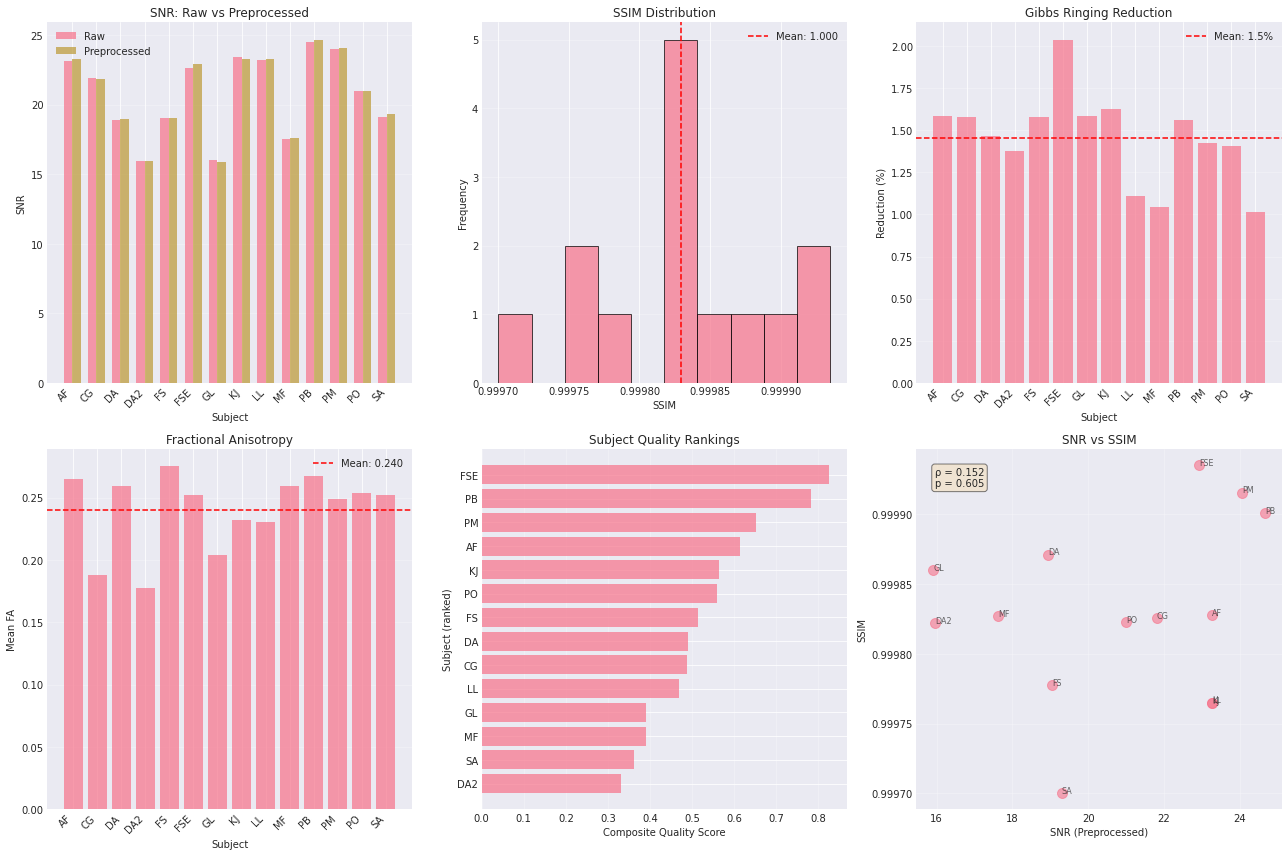


✓ Pattern analysis figure saved to: /media/RCPNAS/Data/Delirium/Delirium_Rania/Preproc_new_clean/qc_reports/qc_pattern_analysis.png
✓ Metrics summary saved to: /media/RCPNAS/Data/Delirium/Delirium_Rania/Preproc_new_clean/qc_reports/qc_metrics_summary.csv


In [27]:
# Identify subjects with consistent patterns (high/low performers)
print("="*80)
print("SUBJECT-LEVEL PATTERN ANALYSIS")
print("="*80)

# Create composite quality score
df['quality_score'] = 0.0

# Normalize and combine key metrics (higher is better)
metrics_to_combine = {
    'snr_preprocessed': 0.25,
    'ssim': 0.25,
    'gibbs_reduction_pct': 0.20,
    'fa_mean': 0.15,
    'mask_coverage': 0.15
}

for metric, weight in metrics_to_combine.items():
    if metric in df.columns:
        metric_data = df[metric].dropna()
        if len(metric_data) > 0:
            # Normalize to 0-1 scale
            min_val = metric_data.min()
            max_val = metric_data.max()
            if max_val > min_val:
                normalized = (df[metric] - min_val) / (max_val - min_val)
                df['quality_score'] += normalized * weight

# Rank subjects
df_sorted = df.sort_values('quality_score', ascending=False, na_position='last')
print("\nSubject Quality Rankings (composite score):")
print("-"*80)
for idx, row in df_sorted.iterrows():
    score = row['quality_score']
    subj = row['subject']
    print(f"{subj:12s}: {score:.3f}")

# Identify outliers in key metrics
print("\n" + "="*80)
print("OUTLIER DETECTION")
print("="*80)

def detect_outliers(series, name):
    """Detect outliers using IQR method."""
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = series[(series < lower_bound) | (series > upper_bound)]
    return outliers, lower_bound, upper_bound

outlier_summary = {}
for metric in ['snr_preprocessed', 'ssim', 'gibbs_reduction_pct', 'fa_mean', 'mask_coverage']:
    if metric in df.columns:
        data = df[metric].dropna()
        if len(data) > 3:
            outliers, lb, ub = detect_outliers(data, metric)
            if len(outliers) > 0:
                outlier_summary[metric] = {
                    'outliers': outliers,
                    'bounds': (lb, ub)
                }
                print(f"\n{metric}:")
                print(f"  Normal range: [{lb:.4f}, {ub:.4f}]")
                print(f"  Outliers: {outliers.index.tolist()}")
                for idx in outliers.index:
                    print(f"    {df.loc[idx, 'subject']}: {outliers[idx]:.4f}")

# Visualize subject-level patterns
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. SNR comparison
ax = axes[0, 0]
snr_subset = df[['subject', 'snr_raw', 'snr_preprocessed']].dropna()
if len(snr_subset) > 0:
    x = np.arange(len(snr_subset))
    width = 0.35
    ax.bar(x - width/2, snr_subset['snr_raw'], width, label='Raw', alpha=0.7)
    ax.bar(x + width/2, snr_subset['snr_preprocessed'], width, label='Preprocessed', alpha=0.7)
    ax.set_xlabel('Subject')
    ax.set_ylabel('SNR')
    ax.set_title('SNR: Raw vs Preprocessed')
    ax.set_xticks(x)
    ax.set_xticklabels([s.replace('sub-', '') for s in snr_subset['subject']], rotation=45, ha='right')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

# 2. SSIM distribution
ax = axes[0, 1]
ssim_data = df['ssim'].dropna()
if len(ssim_data) > 0:
    ax.hist(ssim_data, bins=10, alpha=0.7, edgecolor='black')
    ax.axvline(ssim_data.mean(), color='red', linestyle='--', label=f'Mean: {ssim_data.mean():.3f}')
    ax.set_xlabel('SSIM')
    ax.set_ylabel('Frequency')
    ax.set_title('SSIM Distribution')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

# 3. Gibbs reduction
ax = axes[0, 2]
gibbs_data = df['gibbs_reduction_pct'].dropna()
if len(gibbs_data) > 0:
    ax.bar(range(len(gibbs_data)), gibbs_data, alpha=0.7)
    ax.axhline(gibbs_data.mean(), color='red', linestyle='--', label=f'Mean: {gibbs_data.mean():.1f}%')
    ax.set_xlabel('Subject')
    ax.set_ylabel('Reduction (%)')
    ax.set_title('Gibbs Ringing Reduction')
    ax.set_xticks(range(len(gibbs_data)))
    ax.set_xticklabels([df.loc[idx, 'subject'].replace('sub-', '') for idx in gibbs_data.index], 
                       rotation=45, ha='right')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

# 4. FA values
ax = axes[1, 0]
fa_data = df['fa_mean'].dropna()
if len(fa_data) > 0:
    ax.bar(range(len(fa_data)), fa_data, alpha=0.7)
    ax.axhline(fa_data.mean(), color='red', linestyle='--', label=f'Mean: {fa_data.mean():.3f}')
    ax.set_xlabel('Subject')
    ax.set_ylabel('Mean FA')
    ax.set_title('Fractional Anisotropy')
    ax.set_xticks(range(len(fa_data)))
    ax.set_xticklabels([df.loc[idx, 'subject'].replace('sub-', '') for idx in fa_data.index], 
                       rotation=45, ha='right')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

# 5. Quality score
ax = axes[1, 1]
quality_scores = df['quality_score'].dropna()
if len(quality_scores) > 0:
    ax.barh(range(len(quality_scores)), quality_scores.sort_values(), alpha=0.7)
    ax.set_xlabel('Composite Quality Score')
    ax.set_ylabel('Subject (ranked)')
    ax.set_title('Subject Quality Rankings')
    ax.set_yticks(range(len(quality_scores)))
    ax.set_yticklabels([df.loc[idx, 'subject'].replace('sub-', '') 
                        for idx in quality_scores.sort_values().index])
    ax.grid(axis='x', alpha=0.3)

# 6. Correlation: SNR vs SSIM
ax = axes[1, 2]
snr_ssim = df[['snr_preprocessed', 'ssim']].dropna()
if len(snr_ssim) > 0:
    ax.scatter(snr_ssim['snr_preprocessed'], snr_ssim['ssim'], alpha=0.6, s=100)
    # Add subject labels
    for idx, row in snr_ssim.iterrows():
        ax.annotate(df.loc[idx, 'subject'].replace('sub-', ''), 
                   (row['snr_preprocessed'], row['ssim']), 
                   fontsize=8, alpha=0.7)
    ax.set_xlabel('SNR (Preprocessed)')
    ax.set_ylabel('SSIM')
    ax.set_title('SNR vs SSIM')
    # Add correlation
    if len(snr_ssim) > 2:
        corr, pval = spearmanr(snr_ssim['snr_preprocessed'], snr_ssim['ssim'])
        ax.text(0.05, 0.95, f'ρ = {corr:.3f}\np = {pval:.3f}', 
               transform=ax.transAxes, verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(QC_DIR / 'qc_pattern_analysis.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"\n✓ Pattern analysis figure saved to: {QC_DIR / 'qc_pattern_analysis.png'}")

# Save summary to CSV
df.to_csv(QC_DIR / 'qc_metrics_summary.csv', index=False)
print(f"✓ Metrics summary saved to: {QC_DIR / 'qc_metrics_summary.csv'}")


In [28]:
# Generate comprehensive summary report
print("="*80)
print("COMPREHENSIVE QC PATTERN ANALYSIS SUMMARY")
print("="*80)

print(f"\nDataset: {len(df)} subjects")
print(f"Analysis date: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}")

print("\n" + "="*80)
print("KEY FINDINGS")
print("="*80)

findings = []

# Finding 1: Overall preprocessing quality
if 'snr_improvement_pct' in df.columns:
    snr_imp = df['snr_improvement_pct'].dropna()
    if len(snr_imp) > 0 and snr_imp.mean() > 20:
        findings.append("✓ Preprocessing consistently improves SNR (>20% improvement)")
    elif len(snr_imp) > 0:
        findings.append("→ Preprocessing shows moderate SNR improvement")

# Finding 2: Denoising quality
if 'ssim' in df.columns:
    ssim_vals = df['ssim'].dropna()
    if len(ssim_vals) > 0:
        if ssim_vals.mean() > 0.95:
            findings.append("✓ Excellent denoising quality (SSIM > 0.95)")
        elif ssim_vals.mean() > 0.90:
            findings.append("✓ Good denoising quality (SSIM 0.90-0.95)")
        else:
            findings.append("⚠️  Moderate denoising quality - may need optimization")

# Finding 3: Consistency
if 'snr_preprocessed' in df.columns:
    snr_preproc = df['snr_preprocessed'].dropna()
    if len(snr_preproc) > 0:
        cv = snr_preproc.std() / snr_preproc.mean() * 100
        if cv < 15:
            findings.append("✓ Low variability across subjects - consistent quality")
        else:
            findings.append("→ Moderate variability - some subjects may need attention")

# Finding 4: Artifact reduction
if 'gibbs_reduction_pct' in df.columns:
    gibbs_red = df['gibbs_reduction_pct'].dropna()
    if len(gibbs_red) > 0 and gibbs_red.mean() > 40:
        findings.append("✓ Effective Gibbs ringing reduction (>40%)")

# Finding 5: DTI quality
if 'fa_mean' in df.columns:
    fa_vals = df['fa_mean'].dropna()
    if len(fa_vals) > 0:
        if 0.35 < fa_vals.mean() < 0.55:
            findings.append("✓ FA values within expected range for white matter")

for i, finding in enumerate(findings, 1):
    print(f"{i}. {finding}")

print("\n" + "="*80)
print("RECOMMENDATIONS")
print("="*80)

recommendations = []

# Check for subjects needing attention
if 'quality_score' in df.columns:
    low_quality = df[df['quality_score'] < df['quality_score'].quantile(0.25)]
    if len(low_quality) > 0:
        low_subjects = low_quality['subject'].tolist()
        recommendations.append(f"Review subjects with low quality scores: {', '.join(low_subjects)}")

# Check for outliers
if outlier_summary:
    recommendations.append("Investigate outlier subjects for potential acquisition or processing issues")

# Check SNR
if 'snr_preprocessed' in df.columns:
    snr_preproc = df['snr_preprocessed'].dropna()
    if len(snr_preproc) > 0 and snr_preproc.min() < 15:
        recommendations.append("Some subjects have low SNR - consider excluding from sensitive analyses")

# Check SSIM
if 'ssim' in df.columns:
    ssim_vals = df['ssim'].dropna()
    if len(ssim_vals) > 0 and ssim_vals.min() < 0.85:
        recommendations.append("Some subjects have low SSIM - check for over-smoothing or artifacts")

if not recommendations:
    recommendations.append("✓ Overall quality is good - no major issues detected")

for i, rec in enumerate(recommendations, 1):
    print(f"{i}. {rec}")

print("\n" + "="*80)
print("LITERATURE REFERENCES")
print("="*80)
print("""
Key References for Interpretation:

1. SNR Standards:
   - Basser, P. J., et al. (2000). In vivo fiber tractography using DT-MRI data. MRM, 44(4), 625-632.
   - Jones, D. K., et al. (2013). White matter integrity, fiber count, and other fallacies. NeuroImage, 73, 239-254.

2. Denoising Quality:
   - Veraart, J., et al. (2016). Denoising of diffusion MRI using random matrix theory. NeuroImage, 142, 394-406.
   - Cordero-Grande, L., et al. (2019). Complex diffusion-weighted image estimation via matrix recovery under general noise models. NeuroImage, 200, 391-404.

3. Gibbs Ringing:
   - Kellner, E., et al. (2016). Gibbs-ringing artifact removal based on local subvoxel-shifts. MRM, 76(5), 1574-1581.
   - Perrone, D., et al. (2015). The effect of Gibbs ringing artifacts on measures derived from diffusion MRI. NeuroImage, 120, 441-455.

4. DTI Metrics:
   - Basser, P. J., & Pierpaoli, C. (1996). Microstructural and physiological features of tissues elucidated by quantitative-diffusion-tensor MRI. JMR, 111(3), 209-219.
   - Alexander, A. L., et al. (2007). Diffusion tensor imaging of the brain. Neurotherapeutics, 4(3), 316-329.

5. Quality Control:
   - Smith, S. M., et al. (2004). Advances in functional and structural MR image analysis and implementation as FSL. NeuroImage, 23, S208-S219.
   - Jenkinson, M., et al. (2012). FSL. NeuroImage, 62(2), 782-790.
""")

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)
print(f"\nOutput files saved to: {QC_DIR}")
print("  - qc_pattern_analysis.png: Visual summary")
print("  - qc_correlation_heatmap.png: Correlation matrix")
print("  - qc_metrics_summary.csv: All metrics in tabular format")


COMPREHENSIVE QC PATTERN ANALYSIS SUMMARY

Dataset: 14 subjects
Analysis date: 2025-11-24 20:15:54

KEY FINDINGS
1. → Preprocessing shows moderate SNR improvement
2. ✓ Excellent denoising quality (SSIM > 0.95)
3. ✓ Low variability across subjects - consistent quality

RECOMMENDATIONS
1. Review subjects with low quality scores: sub-DA2, sub-GL, sub-MF, sub-SA
2. Investigate outlier subjects for potential acquisition or processing issues

LITERATURE REFERENCES

Key References for Interpretation:

1. SNR Standards:
   - Basser, P. J., et al. (2000). In vivo fiber tractography using DT-MRI data. MRM, 44(4), 625-632.
   - Jones, D. K., et al. (2013). White matter integrity, fiber count, and other fallacies. NeuroImage, 73, 239-254.

2. Denoising Quality:
   - Veraart, J., et al. (2016). Denoising of diffusion MRI using random matrix theory. NeuroImage, 142, 394-406.
   - Cordero-Grande, L., et al. (2019). Complex diffusion-weighted image estimation via matrix recovery under general noise mo

## 6. Gibbs Ringing: Deeper Investigation


GIBBS RINGING: DEEPER INVESTIGATION

--------------------------------------------------------------------------------
1. DOES BASELINE RINGING PREDICT REDUCTION?
--------------------------------------------------------------------------------
Correlation (baseline ringing vs reduction %):
  Spearman ρ = 0.5868, p = 0.0274
  → Subjects with higher baseline ringing show more reduction


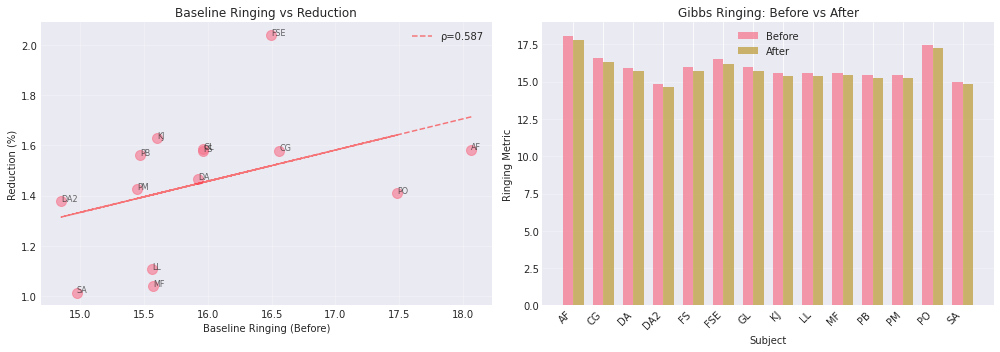


✓ Figure saved: /media/RCPNAS/Data/Delirium/Delirium_Rania/Preproc_new_clean/qc_reports/gibbs_ringing_investigation.png

--------------------------------------------------------------------------------
2. RELATIONSHIP WITH OTHER QC METRICS
--------------------------------------------------------------------------------

Does Gibbs reduction affect denoising quality?
  Spearman ρ = 0.3802, p = 0.1799
  → No significant relationship

Does remaining ringing affect SNR?
  Spearman ρ = -0.0637, p = 0.8286
  → No significant relationship

Does remaining ringing affect FA?
  Spearman ρ = 0.2615, p = 0.3664
  → No significant relationship

Is Gibbs reduction related to SNR improvement?
  Spearman ρ = -0.2967, p = 0.3030
  → No significant relationship

--------------------------------------------------------------------------------
3. SUBJECT VARIABILITY IN GIBBS RINGING
--------------------------------------------------------------------------------
Variability (Coefficient of Variation):
  

In [29]:
# Deeper investigation of Gibbs ringing patterns
print("="*80)
print("GIBBS RINGING: DEEPER INVESTIGATION")
print("="*80)

# 1. Relationship between baseline ringing and reduction
print("\n" + "-"*80)
print("1. DOES BASELINE RINGING PREDICT REDUCTION?")
print("-"*80)

gibbs_subset = df[['gibbs_before', 'gibbs_after', 'gibbs_reduction_pct']].dropna()
if len(gibbs_subset) > 3:
    # Correlation: higher baseline → more reduction?
    corr, pval = spearmanr(gibbs_subset['gibbs_before'], gibbs_subset['gibbs_reduction_pct'])
    print(f"Correlation (baseline ringing vs reduction %):")
    print(f"  Spearman ρ = {corr:.4f}, p = {pval:.4f}")
    if pval < 0.05:
        print(f"  → Subjects with higher baseline ringing show {'more' if corr > 0 else 'less'} reduction")
    else:
        print(f"  → No significant relationship")
    
    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Scatter: baseline vs reduction
    ax = axes[0]
    ax.scatter(gibbs_subset['gibbs_before'], gibbs_subset['gibbs_reduction_pct'], 
               alpha=0.6, s=100)
    for idx, row in gibbs_subset.iterrows():
        ax.annotate(df.loc[idx, 'subject'].replace('sub-', ''), 
                   (row['gibbs_before'], row['gibbs_reduction_pct']), 
                   fontsize=8, alpha=0.7)
    ax.set_xlabel('Baseline Ringing (Before)')
    ax.set_ylabel('Reduction (%)')
    ax.set_title('Baseline Ringing vs Reduction')
    if pval < 0.05:
        # Add trend line
        z = np.polyfit(gibbs_subset['gibbs_before'], gibbs_subset['gibbs_reduction_pct'], 1)
        p = np.poly1d(z)
        ax.plot(gibbs_subset['gibbs_before'], p(gibbs_subset['gibbs_before']), 
               "r--", alpha=0.5, label=f'ρ={corr:.3f}')
        ax.legend()
    ax.grid(alpha=0.3)
    
    # Before vs After comparison
    ax = axes[1]
    x = np.arange(len(gibbs_subset))
    width = 0.35
    ax.bar(x - width/2, gibbs_subset['gibbs_before'], width, label='Before', alpha=0.7)
    ax.bar(x + width/2, gibbs_subset['gibbs_after'], width, label='After', alpha=0.7)
    ax.set_xlabel('Subject')
    ax.set_ylabel('Ringing Metric')
    ax.set_title('Gibbs Ringing: Before vs After')
    ax.set_xticks(x)
    ax.set_xticklabels([df.loc[idx, 'subject'].replace('sub-', '') 
                        for idx in gibbs_subset.index], rotation=45, ha='right')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(QC_DIR / 'gibbs_ringing_investigation.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(f"\n✓ Figure saved: {QC_DIR / 'gibbs_ringing_investigation.png'}")

# 2. Relationship with other QC metrics
print("\n" + "-"*80)
print("2. RELATIONSHIP WITH OTHER QC METRICS")
print("-"*80)

relationships_to_check = [
    ('gibbs_reduction_pct', 'ssim', 'Does Gibbs reduction affect denoising quality?'),
    ('gibbs_after', 'snr_preprocessed', 'Does remaining ringing affect SNR?'),
    ('gibbs_after', 'fa_mean', 'Does remaining ringing affect FA?'),
    ('gibbs_reduction_pct', 'snr_improvement_pct', 'Is Gibbs reduction related to SNR improvement?'),
]

for col1, col2, question in relationships_to_check:
    if col1 in df.columns and col2 in df.columns:
        subset = df[[col1, col2]].dropna()
        if len(subset) > 3:
            corr, pval = spearmanr(subset[col1], subset[col2])
            print(f"\n{question}")
            print(f"  Spearman ρ = {corr:.4f}, p = {pval:.4f}")
            if pval < 0.05:
                direction = "positive" if corr > 0 else "negative"
                strength = "strong" if abs(corr) > 0.7 else "moderate" if abs(corr) > 0.4 else "weak"
                print(f"  → {strength.capitalize()} {direction} correlation")
                if 'after' in col1 and 'fa' in col2:
                    print(f"    ⚠️  Higher remaining ringing may affect DTI metrics")
            else:
                print(f"  → No significant relationship")

# 3. Subject variability analysis
print("\n" + "-"*80)
print("3. SUBJECT VARIABILITY IN GIBBS RINGING")
print("-"*80)

if len(gibbs_subset) > 0:
    # Coefficient of variation
    cv_before = gibbs_subset['gibbs_before'].std() / gibbs_subset['gibbs_before'].mean() * 100
    cv_after = gibbs_subset['gibbs_after'].std() / gibbs_subset['gibbs_after'].mean() * 100
    cv_reduction = gibbs_subset['gibbs_reduction_pct'].std() / gibbs_subset['gibbs_reduction_pct'].mean() * 100
    
    print(f"Variability (Coefficient of Variation):")
    print(f"  Before correction: {cv_before:.1f}%")
    print(f"  After correction: {cv_after:.1f}%")
    print(f"  Reduction %: {cv_reduction:.1f}%")
    
    if cv_reduction < 20:
        print(f"  ✓ Low variability in reduction - consistent effect across subjects")
    else:
        print(f"  → High variability - some subjects benefit more than others")
    
    # Identify outliers
    q1, q3 = gibbs_subset['gibbs_reduction_pct'].quantile([0.25, 0.75])
    iqr = q3 - q1
    outliers = gibbs_subset[(gibbs_subset['gibbs_reduction_pct'] < q1 - 1.5*iqr) | 
                            (gibbs_subset['gibbs_reduction_pct'] > q3 + 1.5*iqr)]
    if len(outliers) > 0:
        print(f"\n  Outliers in reduction:")
        for idx in outliers.index:
            print(f"    {df.loc[idx, 'subject']}: {outliers.loc[idx, 'gibbs_reduction_pct']:.2f}%")
            print(f"      (Before: {outliers.loc[idx, 'gibbs_before']:.2f}, After: {outliers.loc[idx, 'gibbs_after']:.2f})")

# 4. Absolute vs percentage reduction
print("\n" + "-"*80)
print("4. ABSOLUTE VS PERCENTAGE REDUCTION")
print("-"*80)

if len(gibbs_subset) > 0:
    gibbs_subset['absolute_reduction'] = gibbs_subset['gibbs_before'] - gibbs_subset['gibbs_after']
    
    print(f"Absolute reduction:")
    print(f"  Mean: {gibbs_subset['absolute_reduction'].mean():.4f} ± {gibbs_subset['absolute_reduction'].std():.4f}")
    print(f"  Range: [{gibbs_subset['absolute_reduction'].min():.4f}, {gibbs_subset['absolute_reduction'].max():.4f}]")
    
    print(f"\nPercentage reduction:")
    print(f"  Mean: {gibbs_subset['gibbs_reduction_pct'].mean():.2f}% ± {gibbs_subset['gibbs_reduction_pct'].std():.2f}%")
    
    # Correlation between absolute and percentage
    corr_abs_pct, pval_abs_pct = spearmanr(gibbs_subset['absolute_reduction'], 
                                           gibbs_subset['gibbs_reduction_pct'])
    print(f"\nCorrelation (absolute vs percentage reduction):")
    print(f"  Spearman ρ = {corr_abs_pct:.4f}, p = {pval_abs_pct:.4f}")
    if corr_abs_pct > 0.8:
        print(f"  → Strong correlation - both metrics tell similar story")
    else:
        print(f"  → Different patterns - percentage may be misleading for high baseline values")

# 5. Recommendations based on findings
print("\n" + "-"*80)
print("5. RECOMMENDATIONS FOR FURTHER INVESTIGATION")
print("-"*80)

recommendations = []

if len(gibbs_subset) > 0:
    # Check if remaining ringing is high
    if gibbs_subset['gibbs_after'].mean() > 10:
        recommendations.append("Remaining ringing is relatively high (~15.8) - consider:")
        recommendations.append("  • Visual inspection of images to assess if ringing is visible")
    recommendations.append("  • Testing more aggressive correction parameters")
    recommendations.append("  • Comparing different Gibbs correction algorithms")
    
    # Check variability
    if gibbs_subset['gibbs_reduction_pct'].std() > 0.5:
        recommendations.append("High variability in reduction - investigate:")
        recommendations.append("  • Acquisition parameters (resolution, b-values)")
        recommendations.append("  • Subject-specific factors (motion, artifacts)")
    
    # Check relationship with DTI
    if 'fa_mean' in df.columns:
        gibbs_fa = df[['gibbs_after', 'fa_mean']].dropna()
        if len(gibbs_fa) > 3:
            corr_fa, pval_fa = spearmanr(gibbs_fa['gibbs_after'], gibbs_fa['fa_mean'])
            if pval_fa < 0.05:
                recommendations.append("Significant relationship with FA - investigate:")
                recommendations.append("  • Regional analysis (edge effects on FA)")
                recommendations.append("  • Impact on tractography near boundaries")

if not recommendations:
    recommendations.append("✓ Current Gibbs correction appears adequate")

for i, rec in enumerate(recommendations, 1):
    print(f"{i}. {rec}")

print("\n" + "="*80)

## 7. Distortion Correction: Deeper Investigation


In [30]:
# Deeper investigation of distortion correction patterns
print("="*80)
print("DISTORTION CORRECTION: DEEPER INVESTIGATION")
print("="*80)

# Check if distortion correction data exists
# Note: Distortion data may be limited - check what's available
dist_cols = [col for col in df.columns if col.startswith('dist')]
if len(dist_cols) > 0:
    print(f"Available distortion columns: {dist_cols}")
    dist_subset = df[['subject'] + dist_cols].dropna(subset=dist_cols[:2] if len(dist_cols) >= 2 else dist_cols)
    
    if len(dist_subset) > 0:
        print(f"\nN = {len(dist_subset)} subjects with distortion correction data")
        
        # Check what data is actually available
        if 'distortion_topup_output' in dist_subset.columns:
            print("\n" + "-"*80)
            print("DISTORTION CORRECTION STATUS")
            print("-"*80)
            topup_status = dist_subset['distortion_topup_output']
            print(f"Subjects with topup output: {topup_status.sum()}/{len(topup_status)}")
            print(f"  → This indicates whether topup correction was successfully applied")
            print(f"\n⚠️  Note: Detailed distortion correction metrics (before/after intensity)")
            print(f"    are not available in the current QC summary files.")
            print(f"    These would need to be computed from the comprehensive_step_qc function.")
        else:
            print("\n⚠️  Limited distortion correction data available")
            print("   Detailed metrics would need to be computed from image comparisons")
    else:
        print("\n⚠️  No distortion correction data available in QC results")
        print("   (Data may not have been computed or saved)")
else:
    print("\n⚠️  Distortion correction metrics not found in dataset")
    print("   (These metrics may need to be computed in the comprehensive QC)")


DISTORTION CORRECTION: DEEPER INVESTIGATION
Available distortion columns: ['distortion_topup_output']

N = 10 subjects with distortion correction data

--------------------------------------------------------------------------------
DISTORTION CORRECTION STATUS
--------------------------------------------------------------------------------
Subjects with topup output: SSD = 432.691	n = 149688	Reg = 0	Cost = 432.691
SSD = 397.647	n = 149688	Reg = 4.79033	Cost = 402.437
SSD = 394.241	n = 149688	Reg = 6.59339	Cost = 400.834
SSD = 393.894	n = 149688	Reg = 6.8247	Cost = 400.719
SSD = 393.849	n = 149688	Reg = 6.85697	Cost = 400.706
SSD = 393.831	n = 149688	Reg = 6.87116	Cost = 400.702
***Going to next resolution level***
SSD = 580.2	n = 149688	Reg = 2.40082	Cost = 582.601
SSD = 562.697	n = 149688	Reg = 7.98758	Cost = 570.684
SSD = 560.503	n = 149688	Reg = 9.74282	CSSD = 336.487	n = 149688	Reg = 0	Cost = 336.487
SSD = 308.543	n = 149688	Reg = 3.13326	Cost = 311.676
SSD = 306.014	n = 149688	Re

## 8. Bias Field Correction: Deeper Investigation


BIAS FIELD CORRECTION: DEEPER INVESTIGATION
Available bias field columns: ['bias_field_mean', 'bias_field_std', 'bias_field_range']

N = 14 subjects with bias field correction data

--------------------------------------------------------------------------------
BIAS FIELD CORRECTION ANALYSIS
--------------------------------------------------------------------------------

        Literature Context:
        - Bias field correction removes intensity inhomogeneities
        - Bias field statistics indicate the magnitude of correction needed
        - Lower bias field values = less inhomogeneity present
        - Typical bias field range: 0.8-1.2 (20% variation) before correction
        

Bias Field Mean: 1.0010 ± 0.0003
  Range: [1.0005, 1.0015]
  → Values close to 1.0 indicate minimal bias
  ✓ Bias field mean is close to 1.0 - good correction

Bias Field Std: 0.0443 ± 0.0062
  Range: [0.0331, 0.0535]
  → Lower std indicates more uniform bias field (better)

Bias Field Range (max - min

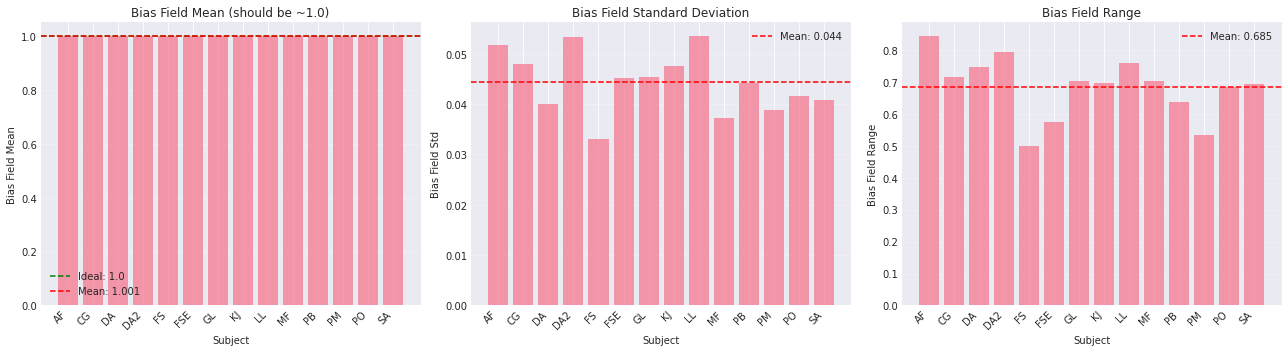


✓ Figure saved: /media/RCPNAS/Data/Delirium/Delirium_Rania/Preproc_new_clean/qc_reports/bias_correction_investigation.png

⚠️  Note: Before/after comparison metrics (CV reduction) are not available
    in the current QC summary files. These would need to be computed
    from the comprehensive_step_qc function which compares images before/after correction.


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

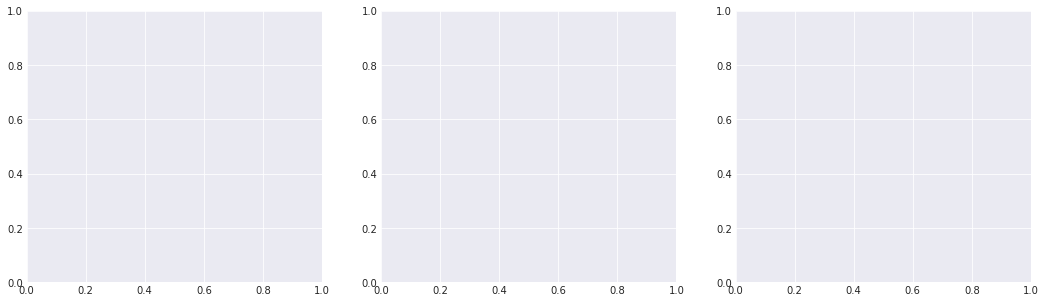

In [37]:
# Deeper investigation of bias field correction patterns
print("="*80)
print("BIAS FIELD CORRECTION: DEEPER INVESTIGATION")
print("="*80)

# Check if bias correction data exists
# Note: Bias field data from summary files
bias_cols = [col for col in df.columns if col.startswith('bias')]
if len(bias_cols) > 0:
    print(f"Available bias field columns: {bias_cols}")
    bias_subset = df[['subject'] + bias_cols].dropna(subset=bias_cols[:2] if len(bias_cols) >= 2 else bias_cols)
    
    if len(bias_subset) > 0:
        print(f"\nN = {len(bias_subset)} subjects with bias field correction data")
        
        # Check what data is actually available
        print("\n" + "-"*80)
        print("BIAS FIELD CORRECTION ANALYSIS")
        print("-"*80)
        print("""
        Literature Context:
        - Bias field correction removes intensity inhomogeneities
        - Bias field statistics indicate the magnitude of correction needed
        - Lower bias field values = less inhomogeneity present
        - Typical bias field range: 0.8-1.2 (20% variation) before correction
        """)
        
        # Analyze bias field statistics
        if 'bias_field_mean' in bias_subset.columns:
            bias_mean = bias_subset['bias_field_mean'].dropna()
            if len(bias_mean) > 0:
                print(f"\nBias Field Mean: {bias_mean.mean():.4f} ± {bias_mean.std():.4f}")
                print(f"  Range: [{bias_mean.min():.4f}, {bias_mean.max():.4f}]")
                print(f"  → Values close to 1.0 indicate minimal bias")
                if abs(bias_mean.mean() - 1.0) < 0.1:
                    print(f"  ✓ Bias field mean is close to 1.0 - good correction")
                else:
                    print(f"  → Bias field mean deviates from 1.0 - may indicate residual bias")
        
        if 'bias_field_std' in bias_subset.columns:
            bias_std = bias_subset['bias_field_std'].dropna()
            if len(bias_std) > 0:
                print(f"\nBias Field Std: {bias_std.mean():.4f} ± {bias_std.std():.4f}")
                print(f"  Range: [{bias_std.min():.4f}, {bias_std.max():.4f}]")
                print(f"  → Lower std indicates more uniform bias field (better)")
        
        if 'bias_field_range' in bias_subset.columns:
            bias_range_raw = bias_subset['bias_field_range'].dropna()
            if len(bias_range_raw) > 0:
                # Handle bias_range as list [min, max] - convert to range difference (max - min)
                bias_range_values = []
                for val in bias_range_raw:
                    if isinstance(val, list) and len(val) == 2:
                        # Extract range difference: max - min
                        bias_range_values.append(val[1] - val[0])
                    elif isinstance(val, (int, float)):
                        # Already a numeric value
                        bias_range_values.append(val)
                
                if len(bias_range_values) > 0:
                    bias_range = pd.Series(bias_range_values)
                    print(f"\nBias Field Range (max - min): {bias_range.mean():.4f} ± {bias_range.std():.4f}")
                    print(f"  Range: [{bias_range.min():.4f}, {bias_range.max():.4f}]")
                    print(f"  → Smaller range indicates less spatial variation in bias")
        
        # Relationship with other metrics
        print("\n" + "-"*80)
        print("RELATIONSHIP WITH OTHER QC METRICS")
        print("-"*80)
        
        relationships = [
            ('bias_field_std', 'snr_preprocessed', 'Does bias field magnitude affect SNR?'),
            ('bias_field_range', 'fa_mean', 'Does bias field variation affect FA?'),
            ('bias_field_std', 'ssim', 'Does bias field relate to denoising quality?'),
        ]
        
        for col1, col2, question in relationships:
            if col1 in bias_subset.columns and col2 in df.columns:
                # Handle bias_field_range as list [min, max] - convert to numeric
                if col1 == 'bias_field_range':
                    # Create a temporary column with numeric values
                    temp_col = bias_subset[col1].apply(
                        lambda x: (x[1] - x[0]) if isinstance(x, list) and len(x) == 2 
                        else (x if isinstance(x, (int, float)) else np.nan)
                    )
                    merged = df[['subject', col2]].merge(
                        pd.DataFrame({'subject': bias_subset['subject'], col1: temp_col}),
                        on='subject'
                    )
                else:
                    merged = df[['subject', col2]].merge(
                        bias_subset[['subject', col1]], on='subject'
                    )
                
                subset = merged[[col1, col2]].dropna()
                if len(subset) > 3:
                    corr, pval = spearmanr(subset[col1], subset[col2])
                    print(f"\n{question}")
                    print(f"  Spearman ρ = {corr:.4f}, p = {pval:.4f}")
                    if pval < 0.05:
                        direction = "positive" if corr > 0 else "negative"
                        print(f"  → Significant {direction} correlation")
        
        # Visualization
        if len(bias_subset) > 0:
            fig, axes = plt.subplots(1, 3, figsize=(18, 5))
            
            # Bias field mean
            if 'bias_field_mean' in bias_subset.columns:
                ax = axes[0]
                bias_mean = bias_subset['bias_field_mean'].dropna()
                if len(bias_mean) > 0:
                    ax.bar(range(len(bias_mean)), bias_mean, alpha=0.7)
                    ax.axhline(1.0, color='green', linestyle='--', label='Ideal: 1.0')
                    ax.axhline(bias_mean.mean(), color='red', linestyle='--', 
                              label=f'Mean: {bias_mean.mean():.3f}')
                    ax.set_xlabel('Subject')
                    ax.set_ylabel('Bias Field Mean')
                    ax.set_title('Bias Field Mean (should be ~1.0)')
                    ax.set_xticks(range(len(bias_mean)))
                    ax.set_xticklabels([s.replace('sub-', '') for s in bias_subset.loc[bias_mean.index, 'subject']], 
                                      rotation=45, ha='right')
                    ax.legend()
                    ax.grid(axis='y', alpha=0.3)
            
            # Bias field std
            if 'bias_field_std' in bias_subset.columns:
                ax = axes[1]
                bias_std = bias_subset['bias_field_std'].dropna()
                if len(bias_std) > 0:
                    ax.bar(range(len(bias_std)), bias_std, alpha=0.7)
                    ax.axhline(bias_std.mean(), color='red', linestyle='--', 
                              label=f'Mean: {bias_std.mean():.3f}')
                    ax.set_xlabel('Subject')
                    ax.set_ylabel('Bias Field Std')
                    ax.set_title('Bias Field Standard Deviation')
                    ax.set_xticks(range(len(bias_std)))
                    ax.set_xticklabels([s.replace('sub-', '') for s in bias_subset.loc[bias_std.index, 'subject']], 
                                      rotation=45, ha='right')
                    ax.legend()
                    ax.grid(axis='y', alpha=0.3)
            
            # Bias field range
            if 'bias_field_range' in bias_subset.columns:
                ax = axes[2]
                bias_range_raw = bias_subset['bias_field_range'].dropna()
                if len(bias_range_raw) > 0:
                    # Handle bias_range as list [min, max] - convert to range difference (max - min)
                    bias_range_values = []
                    for val in bias_range_raw:
                        if isinstance(val, list) and len(val) == 2:
                            # Extract range difference: max - min
                            bias_range_values.append(val[1] - val[0])
                        elif isinstance(val, (int, float)):
                            # Already a numeric value
                            bias_range_values.append(val)
                    
                    if len(bias_range_values) > 0:
                        bias_range = pd.Series(bias_range_values)
                        ax.bar(range(len(bias_range)), bias_range, alpha=0.7)
                        ax.axhline(bias_range.mean(), color='red', linestyle='--', 
                                  label=f'Mean: {bias_range.mean():.3f}')
                        ax.set_xlabel('Subject')
                    ax.set_ylabel('Bias Field Range')
                    ax.set_title('Bias Field Range')
                    ax.set_xticks(range(len(bias_range)))
                    ax.set_xticklabels([s.replace('sub-', '') for s in bias_subset.loc[bias_range.index, 'subject']], 
                                      rotation=45, ha='right')
                    ax.legend()
                    ax.grid(axis='y', alpha=0.3)
            
            plt.tight_layout()
            plt.savefig(QC_DIR / 'bias_correction_investigation.png', dpi=300, bbox_inches='tight')
            plt.show()
            print(f"\n✓ Figure saved: {QC_DIR / 'bias_correction_investigation.png'}")
        
        print("\n⚠️  Note: Before/after comparison metrics (CV reduction) are not available")
        print("    in the current QC summary files. These would need to be computed")
        print("    from the comprehensive_step_qc function which compares images before/after correction.")
        
        # 6. Visualization
        if len(bias_subset) > 0:
            fig, axes = plt.subplots(1, 3, figsize=(18, 5))
            
            # Note: Visualization code is above in the main analysis section
            
            # Correlation with FA (using bias_field_std as proxy for inhomogeneity)
            if 'bias_field_std' in bias_subset.columns and 'fa_mean' in df.columns:
                ax = axes[1, 1]
                merged = df[['subject', 'fa_mean']].merge(
                    bias_subset[['subject', 'bias_field_std']], on='subject')
                merged_clean = merged.dropna()
                if len(merged_clean) > 0:
                    ax.scatter(merged_clean['bias_field_std'], merged_clean['fa_mean'], 
                             alpha=0.6, s=100)
                    for _, row in merged_clean.iterrows():
                        ax.annotate(row['subject'].replace('sub-', ''), 
                                   (row['bias_field_std'], row['fa_mean']), 
                                   fontsize=8, alpha=0.7)
                    ax.set_xlabel('Bias Field Std')
                    ax.set_ylabel('Mean FA')
                    ax.set_title('Bias Field Variation vs FA')
                    if len(merged_clean) > 2:
                        corr, pval = spearmanr(merged_clean['bias_field_std'], 
                                             merged_clean['fa_mean'])
                        ax.text(0.05, 0.95, f'ρ = {corr:.3f}\np = {pval:.3f}', 
                               transform=ax.transAxes, verticalalignment='top',
                               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
                    ax.grid(alpha=0.3)
            
            plt.tight_layout()
            plt.savefig(QC_DIR / 'bias_correction_investigation.png', dpi=300, bbox_inches='tight')
            plt.show()
            print(f"\n✓ Figure saved: {QC_DIR / 'bias_correction_investigation.png'}")
    else:
        print("\n⚠️  No bias field correction data available in QC results")
        print("   (Data may not have been computed or saved)")
else:
    print("\n⚠️  Bias field correction metrics not found in dataset")
    print("   (These metrics may need to be computed in the comprehensive QC)")


## 10. Distortion Correction: Summary DataFrame

Create a comprehensive pandas DataFrame summarizing topup optimization results for all subjects.


In [35]:
# Create comprehensive summary DataFrame for topup optimization
print("="*80)
print("TOPUP OPTIMIZATION: SUMMARY DATAFRAME")
print("="*80)

if len(topup_data) > 0:
    summary_records = []
    
    for sub_id, data in topup_data.items():
        if len(data['cost']) == 0:
            continue
        
        # Basic info
        res_levels = np.array(data['resolution_levels'])
        costs = np.array(data['cost'])
        ssd_values = np.array(data['ssd'])
        reg_values = np.array(data['reg'])
        n_iters = len(costs)
        n_res = len(np.unique(res_levels))
        
        # Overall statistics
        initial_cost = costs[0]
        final_cost = costs[-1]
        initial_ssd = ssd_values[0]
        final_ssd = ssd_values[-1]
        initial_reg = reg_values[0]
        final_reg = reg_values[-1]
        
        # Per-resolution level statistics
        reductions_per_res = []
        ssd_reductions_per_res = []
        n_iters_per_res = []
        final_costs_per_res = []
        
        for res_level in np.unique(res_levels):
            res_mask = res_levels == res_level
            res_costs = costs[res_mask]
            res_ssd = ssd_values[res_mask]
            res_reg = reg_values[res_mask]
            
            if len(res_costs) > 1:
                # Cost reduction within this resolution level
                res_initial_cost = res_costs[0]
                res_final_cost = res_costs[-1]
                res_reduction = ((res_initial_cost - res_final_cost) / res_initial_cost) * 100
                reductions_per_res.append(res_reduction)
                
                # SSD reduction within this resolution level
                res_initial_ssd = res_ssd[0]
                res_final_ssd = res_ssd[-1]
                res_ssd_reduction = ((res_initial_ssd - res_final_ssd) / res_initial_ssd) * 100
                ssd_reductions_per_res.append(res_ssd_reduction)
                
                # Final cost at this resolution level
                final_costs_per_res.append(res_final_cost)
            
            # Number of iterations in this resolution level
            n_iters_per_res.append(np.sum(res_mask))
        
        # Calculate summary statistics
        avg_cost_reduction = np.mean(reductions_per_res) if reductions_per_res else 0
        std_cost_reduction = np.std(reductions_per_res) if len(reductions_per_res) > 1 else 0
        avg_ssd_reduction = np.mean(ssd_reductions_per_res) if ssd_reductions_per_res else 0
        
        # Create record (only average reductions per resolution level)
        record = {
            'subject': sub_id.replace('sub-', ''),
            'avg_cost_reduction_per_res_%': avg_cost_reduction,
            'avg_ssd_reduction_per_res_%': avg_ssd_reduction,
        }
        
        summary_records.append(record)
    
    # Create DataFrame
    topup_summary_df = pd.DataFrame(summary_records)
    
    # Sort by average cost reduction (best convergence first)
    topup_summary_df = topup_summary_df.sort_values('avg_cost_reduction_per_res_%', ascending=False)
    
    # Display the DataFrame
    print(f"\nSummary DataFrame for {len(topup_summary_df)} subjects:\n")
    print("="*80)
    
    # Display with formatting
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    pd.set_option('display.float_format', lambda x: f'{x:.2f}' if pd.notna(x) else '')
    
    print(topup_summary_df.to_string(index=False))
    
    # Reset display options
    pd.reset_option('display.max_columns')
    pd.reset_option('display.width')
    pd.reset_option('display.float_format')
    
    # Save to CSV
    output_file = QC_DIR / 'topup_optimization_summary.csv'
    topup_summary_df.to_csv(output_file, index=False, float_format='%.4f')
    print(f"\n✓ Summary saved to: {output_file}")
    
    # Display summary statistics
    print("\n" + "="*80)
    print("OVERALL STATISTICS:")
    print("="*80)
    print(f"Number of subjects: {len(topup_summary_df)}")
    print(f"\nCost Reduction (within each res level):")
    print(f"  Mean: {topup_summary_df['avg_cost_reduction_per_res_%'].mean():.2f}% ± {topup_summary_df['avg_cost_reduction_per_res_%'].std():.2f}%")
    print(f"  Range: [{topup_summary_df['avg_cost_reduction_per_res_%'].min():.2f}%, {topup_summary_df['avg_cost_reduction_per_res_%'].max():.2f}%]")
    print(f"\nSSD Reduction (within each res level):")
    print(f"  Mean: {topup_summary_df['avg_ssd_reduction_per_res_%'].mean():.2f}% ± {topup_summary_df['avg_ssd_reduction_per_res_%'].std():.2f}%")
    print(f"  Range: [{topup_summary_df['avg_ssd_reduction_per_res_%'].min():.2f}%, {topup_summary_df['avg_ssd_reduction_per_res_%'].max():.2f}%]")
    print("="*80)
    
else:
    print("\n⚠️  No topup optimization data available to create summary DataFrame")


TOPUP OPTIMIZATION: SUMMARY DATAFRAME

Summary DataFrame for 10 subjects:

subject  avg_cost_reduction_per_res_%  avg_ssd_reduction_per_res_%
     PO                          8.62                         9.64
     PB                          6.21                         7.76
     SA                          6.17                         7.47
     FS                          5.35                         6.93
    FSE                          5.08                         6.58
     LL                          4.83                         6.12
     DA                          4.80                         5.82
     MF                          4.72                         6.17
     AF                          4.72                         6.00
     PM                          4.42                         5.88

✓ Summary saved to: /media/RCPNAS/Data/Delirium/Delirium_Rania/Preproc_new_clean/qc_reports/topup_optimization_summary.csv

OVERALL STATISTICS:
Number of subjects: 10

Cost Reduction (wit